In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import savgol_filter
from sklearn.preprocessing import FunctionTransformer

In [1]:
import pandas as pd
import numpy as np

# Загрузка данных

file = pd.read_csv("dataset/Staphylococcus.CSV", header=None, sep=';',decimal=",",names=["Wavenumber","Intensity"]).apply(lambda col: pd.to_numeric(col, errors='coerce'))
file1 = pd.read_csv("dataset/Staphylococcus_1.CSV",header=None, sep=";",decimal=",",names=["Wavenumber","Intensity"]).apply(lambda col: pd.to_numeric(col, errors='coerce'))
file2 = pd.read_csv("dataset/Staphylococcus_2.CSV",header=None, sep=";",decimal=",",names=["Wavenumber","Intensity"]).apply(lambda col: pd.to_numeric(col, errors='coerce'))

ex = pd.read_excel("dataset/Pseudomonas.xlsx",names=["Wavenumber","Intensity"])
ex1 = pd.read_excel("dataset/Pseudomonas_1.xlsx",names=["Wavenumber","Intensity"])
ex2 = pd.read_excel("dataset/Pseudomonas_2.xlsx",names=["Wavenumber","Intensity"])

file["spectrumID"] = 0
file1["spectrumID"] = 1
file2["spectrumID"] = 2
ex["spectrumID"] = 3
ex1["spectrumID"] = 4
ex2["spectrumID"] = 5

staphy = pd.concat([file,file1,file2],ignore_index=True)
staphy["Class"] = 0

pseudo = pd.concat([ex,ex1,ex2],ignore_index=True)
pseudo["Class"] = 1

data = pd.concat([staphy,pseudo],ignore_index=True)

df_pivoted = data.pivot(index="spectrumID",columns="Wavenumber",values="Intensity").reset_index()

df_pivoted = df_pivoted.merge(data[['spectrumID', 'Class']].drop_duplicates(), on='spectrumID')


In [15]:
ex

,Wavenumber,Intensity,spectrumID
0,889.21655,5137,3
1,890.44634,5093,3
2,891.67596,5012,3
3,892.90540,5214,3
4,894.13468,5195,3
...,...,...,...
2043,3089.97690,5075,3
2044,3090.92001,5074,3
2045,3091.86300,5158,3
2046,3092.80588,5205,3


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

# Load pivoted data
df = pd.read_csv('restructured_dataset.csv')
X = df.drop(['spectrumID', 'Class'], axis=1)
y = df['Class']

# Split data (stratify if classes exist)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)
def extract_features(X):
    # Пики
    peaks = np.argmax(X, axis=1)
    peak_intensities = np.max(X, axis=1)
    
    # Статистические признаки
    stats = np.hstack([
        np.mean(X, axis=1)[:, np.newaxis],
        np.std(X, axis=1)[:, np.newaxis],
        np.median(X, axis=1)[:, np.newaxis]
    ])
    
    return np.hstack([peaks[:, np.newaxis], peak_intensities[:, np.newaxis], stats])

# Build a simple pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Fill NaNs with mean intensity
    ('feature_extraction', FunctionTransformer(extract_features)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=1)),
    ('svc', SVC(kernel='linear'))
])

# Train and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, savgol_filter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from pywt import wavedec
from sklearn.model_selection import StratifiedKFold
import warnings

# -------------------------------------------------------------------------------------
# 1. Data Augmentation (Outside Pipeline)
# -------------------------------------------------------------------------------------
class SpectralAugmenter:
    """Аугментация спектров с защитой от аномальных значений"""
    def __init__(self, noise_factor=0.02, n_augment=20):
        self.noise_factor = noise_factor
        self.n_augment = n_augment

    def _safe_noise(self, shape):
        """Генерация безопасного шума"""
        noise = self.noise_factor * np.random.randn(*shape)
        return np.clip(noise, -3*self.noise_factor, 3*self.noise_factor)

    def augment(self, X, y):
        X_aug, y_aug = [], []
        for i in range(len(X)):
            # Обработка исходного спектра
            spec = np.nan_to_num(X[i], nan=0.0)
            
            X_aug.append(spec)
            y_aug.append(y[i])
            
            # Генерация аугментированных данных
            for _ in range(self.n_augment):
                noise = self._safe_noise(spec.shape)
                augmented = spec + noise
                augmented = np.nan_to_num(augmented, nan=0.0)
                X_aug.append(augmented)
                y_aug.append(y[i])
                
        return np.array(X_aug), np.array(y_aug)



# -------------------------------------------------------------------------------------
# 2. Feature Engineering with Robust Peak Detection
# -------------------------------------------------------------------------------------
class PeakPCAFeatures(BaseEstimator, TransformerMixin):
    """Extract consistent peak features with smoothing and padding."""
    def __init__(self, n_peaks=5, pca_components=2, 
                 window_length=11, polyorder=3, peak_thresh=0.5):
        self.n_peaks = n_peaks
        self.pca_components = pca_components
        self.window_length = window_length
        self.polyorder = polyorder
        self.peak_thresh = peak_thresh
        self.pca = PCA(n_components=self.pca_components)

    def extract_peaks(self, spectrum):
        smoothed = savgol_filter(spectrum, 
                               window_length=self.window_length,
                               polyorder=self.polyorder)
        peaks, props = find_peaks(smoothed, height=self.peak_thresh)

        if len(peaks) == 0:
            return np.zeros(2 * self.n_peaks)
            
        # Select top n_peaks by height
        heights = props['peak_heights']
        idx_sorted = np.argsort(heights)[-self.n_peaks:]
        top_peaks = peaks[idx_sorted]
        top_heights = heights[idx_sorted]
        
        # Pad with zeros if needed
        pad_len = self.n_peaks - len(top_peaks)
        if pad_len > 0:
            top_peaks = np.pad(top_peaks, (0, pad_len), mode='constant')
            top_heights = np.pad(top_heights, (0, pad_len), mode='constant')
            
        return np.concatenate([top_peaks, top_heights])

    def fit(self, X, y=None):
        X_peaks = np.array([self.extract_peaks(spec) for spec in X])
        self.pca.fit(X_peaks)
        return self

    def transform(self, X):
        X_peaks = np.array([self.extract_peaks(spec) for spec in X])
        return self.pca.transform(X_peaks)
    
    
class WaveletFeatures(BaseEstimator, TransformerMixin):
    """Extract wavelet decomposition coefficients"""
    def __init__(self, wavelet='db1', level=3, n_coeffs=20):
        self.wavelet = wavelet
        self.level = level
        self.n_coeffs = n_coeffs

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for spec in X:
            coeffs = wavedec(spec, self.wavelet, level=self.level)
            flattened = np.concatenate([c[:self.n_coeffs] for c in coeffs])
            features.append(flattened[:self.n_coeffs])
        return np.array(features)


# -------------------------------------------------------------------------------------
# 3. Corrected Pipeline Implementation
# -------------------------------------------------------------------------------------
# Load and prepare dat
df = pd.read_csv('restructured_dataset.csv')
X = df.drop(['spectrumID', 'Class'], axis=1).values
y = df['Class'].values

# Проверка исходных данных
print("NaN в исходных данных:", np.isnan(X).sum())
print("Inf в исходных данных:", np.isinf(X).sum())

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

# Аугментация данных
augmenter = SpectralAugmenter(noise_factor=0.2, n_augment=50)
X_train_aug, y_train_aug = augmenter.augment(X_train, y_train)

# Функция проверки и очистки данных
def clean_data(X, y):
    X = np.nan_to_num(X, nan=0.0)
    X = np.clip(X, -1e6, 1e6)  # Ограничение аномальных значений
    return X, y

X_train_aug, y_train_aug = clean_data(X_train_aug, y_train_aug)

# Пайплайн
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', MinMaxScaler()),
    ('features', PeakPCAFeatures()),
    ('classifier', RandomForestClassifier(class_weight='balanced'))
])

# Параметры для GridSearch
param_grid = [
    {
        'features': [PeakPCAFeatures()],
        'features__n_peaks': [3, 5],
        'features__pca_components': [2, 5],
        'features__window_length': [11, 21],
        'features__peak_thresh': [0.3, 0.5],
        'classifier__n_estimators': [100, 200]
    },
    {
        'features': [WaveletFeatures()],
        'features__wavelet': ['db1', 'haar'],
        'features__level': [3, 4],
        'features__n_coeffs': [20, 30],
        'classifier__n_estimators': [100, 200]
    }
]

# Настройка и запуск GridSearch
search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(3),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    search.fit(X_train_aug, y_train_aug)

# Результаты
print(f"Лучшая точность: {search.best_score_:.2f}")
best_model = search.best_estimator_
best_model.fit(X_train_aug, y_train_aug)
print(f"Точность на тесте: {best_model.score(X_test, y_test):.2f}")
import joblib

joblib.dump(best_model, 'model.joblib')

In [ ]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

peak_extractor = PeakPCAFeatures(n_peaks=5, pca_components=2)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train_aug)
X_pca = peak_extractor.fit_transform(X_scaled)

le = LabelEncoder()
codes = le.fit_transform(y_train_aug)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=codes, alpha=0.7)
plt.title('PCA проекция пиковых признаков')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Классы')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Предполагается, что X_pca содержит проекции на PC1 и PC2
# y содержит метки классов

# Получаем уникальные классы
unique_classes = np.unique(y_train_aug)

# Создаем цветовую карту
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))

# Рисуем график
plt.figure(figsize=(8, 6))
for i, cls in enumerate(unique_classes):
    mask = y_train_aug == cls
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[i]], label=cls, alpha=0.7)

plt.title('PCA проекция пиковых признаков')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Классы', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
ypred=best_model.predict(X_test)
print(confusion_matrix(y_test,ypred))
print(accuracy_score(y_test,ypred))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import savgol_filter
from sklearn.preprocessing import FunctionTransformer

# 1. Загрузка данных
df = pd.read_csv('dataset.csv')

X = df.iloc[:, 1:-1]  # Берем только Wavenumber и Intensity
y = df.iloc[:, -1]    # Класс

# 2. Предобработка
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        # # Применение фильтра
        X_smooth = savgol_filter(X,window_length=3, polyorder=2,axis=1,mode="constant")

        X_scaled = self.scaler.fit_transform(X_smooth)
        return X_scaled


# 3. Извлечение признаков
def extract_features(X):
    # Пики
    peaks = np.argmax(X, axis=1)
    peak_intensities = np.max(X, axis=1)
    
    # Статистические признаки
    stats = np.hstack([
        np.mean(X, axis=1)[:, np.newaxis],
        np.std(X, axis=1)[:, np.newaxis],
        np.median(X, axis=1)[:, np.newaxis]
    ])
    
    return np.hstack([peaks[:, np.newaxis], peak_intensities[:, np.newaxis], stats])

# 4. Создание пайплайна
pipeline = Pipeline([
    ('preprocessing', Preprocessor()),
    ('feature_extraction', FunctionTransformer(extract_features)),
    ('pca', PCA(n_components=0.95)),
    ('classifier', RandomForestClassifier())
])


# 5. Обучение и оценка
def train_evaluate_pipeline(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.show()

# 6. Оптимизация гиперпараметров
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'pca__n_components': [0.9, 0.95]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3)

try:
    train_evaluate_pipeline(X, y)
except ValueError as e:
    print(f"Критическая ошибка: {e}")
    print("Рекомендуемые действия:")
    print("- Проверьте количество признаков в данных")
    print("- Уменьшите window_length до 3-5")
    print("- Используйте mode='nearest' или mode='mirror'")

In [ ]:
testme = pd.read_excel("dataset/Pseudomonas.xlsx",names=["Wavenumber","Intensit"])
test= pd.read_csv("dataset/Staphylococcus.CSV",names=["Wave","INte"],decimal=",",sep=";")

pred = pipeline.predict(test.apply(lambda col:pd.to_numeric(col,errors="coerce")))
pred1 = pipeline.predict(testme.apply(lambda col:pd.to_numeric(col,errors="coerce")))

value, counts = np.unique(pred1, return_counts=True)
print(value)
print(counts)

In [ ]:
# Проверка распределения классов
print(y.value_counts())

# Проверка на дубликаты
print("Дубликаты в данных:", df.duplicated().sum())

# Кросс-валидация
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X, y, cv=5)
print("Кросс-валидация:", scores)

In [ ]:
# Важность признаков после PCA
pca = pipeline.named_steps['pca']
print("Объясненная дисперсия:", pca.explained_variance_ratio_)


In [ ]:
# Генерация тестовых данных
from sklearn.datasets import make_classification
X_synth, y_synth = make_classification(
    n_samples=1000,
    n_features=2,
    n_classes=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_clusters_per_class=1
)

# Проверка модели
pipeline.fit(X, y)
print("Accuracy на синтетических данных:", pipeline.score(X_synth, y_synth))

In [ ]:
# Альтернатива: добавление шума к исходным данным
import numpy as np

def generate_synthetic_spectra(X_real: np.array, noise_level: float = 500):
    """Генерация синтетических спектров на основе реальных данных"""
    noise = np.random.normal(0, noise_level, X_real.shape)
    return X_real + noise

# Пример использования
X_synth = np.vstack([
    generate_synthetic_spectra(X[y == 0]),
    generate_synthetic_spectra(X[y == 1])
])  
y_synth = np.array([0]*len(X[y==0]) + [1]*len(X[y==1]))

# Проверка модели
pipeline.fit(X, y)
print("Accuracy на синтетических спектрах:", pipeline.score(X_synth, y_synth))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("dataset.csv",sep=",",decimal=".")
scaler = MinMaxScaler()

X = data[data["Class"]==1].iloc[:,1:2].apply(lambda col: pd.to_numeric(col,errors="coerce"))
X1 = data[data["Class"]==0].iloc[:,1:2].apply(lambda col: pd.to_numeric(col,errors="coerce"))

X_scaled = scaler.fit_transform(X)
X1_scaled = scaler.fit_transform(X1)

plt.figure(figsize=[12,6],dpi=300)
plt.plot(X_scaled, label="Класс 0")
plt.plot(X1_scaled, label = "Класс 1")
plt.legend()
plt.grid()

In [ ]:
x_smooth = savgol_filter(X_scaled,window_length=11,polyorder=5,mode="constant")
plt.plot(x_smooth,label="x_smooth")
plt.plot(X_scaled,label="scaled")
plt.plot(X1_scaled,label="x")
plt.legend()
plt.show()


In [ ]:
from scipy.signal import savgol_filter

some = np.array([1,4,5,6,23,14])
sc = savgol_filter(some,window_length=11,polyorder=3, mode="constant")
plt.plot(some)
plt.plot(sc)


In [ ]:
df

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv("restructured_dataset.csv")
scaler = MinMaxScaler

# Выбираем только столбцы‑признаки (все числовые кроме Class)
intensity_cols = [c for c in df.columns 
                  if c not in ("Unnamed: 0", "spectrumID", "Class")]

# Приведём названия столбцов к float и отсортируем
wavs = sorted(map(float, intensity_cols))
df_feats = df.set_index(["spectrumID", "Class"])[map(str, wavs)]
df_feats


In [ ]:
# Применяем интерполяцию по строкам (axis=1)
# method='linear' — линейная; limit_direction='both' — заполняем краевые NaN
df_interp = df_feats.interpolate(method="linear", axis=1, limit_direction="both")
df_interp

In [ ]:
# Проверим, остались ли NaN
nan_counts = df_interp.isna().sum(axis=1)
print("Максимум NaN в строке после интерполяции:", nan_counts.max())

# Если после интерполяции всё ещё есть пропуски, их можно:
# - заполнить константой: df_interp.fillna(0)
# - или отбросить спектры с слишком большим числом NaN:
#   mask = nan_counts < threshold
#   df_final = df_interp[mask]


In [ ]:
# Восстановим столбец Class в готовый DataFrame
df_final = df_interp.reset_index() \
                    .merge(df[["spectrumID", "Class"]].drop_duplicates(),
                           on="spectrumID")
df_final

In [ ]:
p=df_final.iloc[5:8,:]
p

In [ ]:
df_final.to_csv("interpolated.csv")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

# 1. Load restructured dataset
df = pd.read_csv("restructured_dataset.csv")

# 2. Separate features (intensities) and target
meta_cols = {"Unnamed: 0", "spectrumID", "Class"}
wavs = np.array(sorted([float(c) for c in df.columns if c not in meta_cols]))
X_raw = df[[str(w) for w in wavs]].values
y = df["Class"].values
groups = df["spectrumID"].values

# 3. Interpolate missing values (linear) across each spectrum
X_interp = pd.DataFrame(X_raw, columns=wavs).interpolate(
    method="linear", axis=1, limit_direction="both"
).values

# 4. Augmentation function: add Gaussian noise and slight shift in wavenumber axis
def augment_spectra(X, y, groups, n_aug=20, noise_level=0.02, shift_max=0.5):
    X_aug, y_aug, g_aug = [], [], []
    for xi, yi, gi in zip(X, y, groups):
        for _ in range(n_aug):
            noise = np.random.normal(scale=noise_level * np.std(xi), size=xi.shape)
            shift = np.random.uniform(-shift_max, shift_max, size=xi.shape)
            # simulate shift by a small phase: roll and blend
            xi_shifted = np.interp(wavs, wavs + shift, xi, left=xi[0], right=xi[-1])
            X_aug.append(xi_shifted + noise)
            y_aug.append(yi)
            g_aug.append(gi)
    # combine original + augmented
    return np.vstack([X, np.array(X_aug)]), np.hstack([y, np.array(y_aug)]), np.hstack([groups, np.array(g_aug)])

# 5. Augment training data (augmentation should be done inside CV ideally, shown here for illustration)
X_aug, y_aug, groups_aug = augment_spectra(X_interp, y, groups, n_aug=10, noise_level=0.02, shift_max=0.5)

# 6. Build a modeling pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

# 7. Evaluate with Leave-One-Spectrum-Out CV
gkf = GroupKFold(n_splits=len(np.unique(groups_aug)))
cv_scores = cross_val_score(pipeline, X_aug, y_aug, groups=groups_aug, cv=gkf, scoring="balanced_accuracy", n_jobs=-1)
print("LOSO balanced accuracy scores:", cv_scores)
print("Mean BAL accuracy:", cv_scores.mean())

# 8. Detailed evaluation: confusion matrix and ROC curve for one fold
# Here we pick the first fold as an example
train_idx, test_idx = list(gkf.split(X_aug, y_aug, groups_aug))[0]
pipeline.fit(X_aug[train_idx], y_aug[train_idx])
y_pred = pipeline.predict(X_aug[test_idx])
y_proba = pipeline.predict_proba(X_aug[test_idx])[:, 1]

# Confusion Matrix
disp_cm = ConfusionMatrixDisplay.from_predictions(y_aug[test_idx], y_pred)
disp_cm.ax_.set_title("Confusion Matrix (Fold 1)")

# ROC Curve
fpr, tpr, _ = roc_curve(y_aug[test_idx], y_proba)
roc_auc = auc(fpr, tpr)
disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp_roc.plot()
plt.title(f"ROC Curve (Fold 1) - AUC: {roc_auc:.2f}")

plt.show()


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

# This gives you probability estimates for every sample, via LOSO CV:
y_proba_all = cross_val_predict(
    pipeline, X_aug, y_aug, groups=groups_aug,
    cv=gkf, method="predict_proba", n_jobs=-1
)[:,1]

# Now global AUC:
global_auc = roc_auc_score(y_aug, y_proba_all)
print("Global ROC AUC:", global_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_aug[test_idx], y_proba)
roc_auc = auc(fpr, tpr)
disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=global_auc)
disp_roc.plot()
plt.title(f"ROC Curve (Fold 1) - AUC: {roc_auc:.2f}")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import numpy as np
from scipy.interpolate import interp1d
def plot_peaks(wavenumbers, intensity, min_prominence=0.01, top_n=5):
    # Найдём пики
    peaks, props = find_peaks(intensity, prominence=min_prominence)
    widths, width_heights, left_ips, right_ips = peak_widths(intensity, peaks, rel_height=0.5)

    # Отсортируем по высоте и оставим top_n
    top_idxs = np.argsort(intensity[peaks])[-top_n:] if len(peaks) >= top_n else range(len(peaks))
    selected_peaks = peaks[top_idxs]

    # Построим график
    plt.figure(figsize=(12, 5))
    plt.plot(wavenumbers, intensity, label='Спектр')
    plt.plot(wavenumbers[selected_peaks], intensity[selected_peaks], "x", color='red', label='Пики')
    
    for i in top_idxs:
        center = wavenumbers[peaks[i]]
        width = right_ips[i] - left_ips[i]
        height = width_heights[i]
        plt.hlines(y=height, xmin=wavenumbers[int(left_ips[i])], xmax=wavenumbers[int(right_ips[i])], color='green', linestyle='--')

    plt.xlabel("Волновое число (см⁻¹)")
    plt.ylabel("Интенсивность (а.е.)")
    plt.title("Выделенные пики и их ширины (на полувысоте)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df = pd.read_csv("restructured_dataset.csv")
meta_cols = {"Unnamed: 0", "spectrumID", "Class"}
wavs = np.array(sorted([float(c) for c in df.columns if c not in meta_cols]))
X_raw = df[[str(w) for w in wavs]].values
y = df["Class"].values
groups = df["spectrumID"].values

# Interpolate missing values
X_interp = np.vstack([
    interp1d(wavs[~np.isnan(row)], row[~np.isnan(row)], kind='nearest',
             bounds_error=False)(wavs)
    for row in X_raw
])


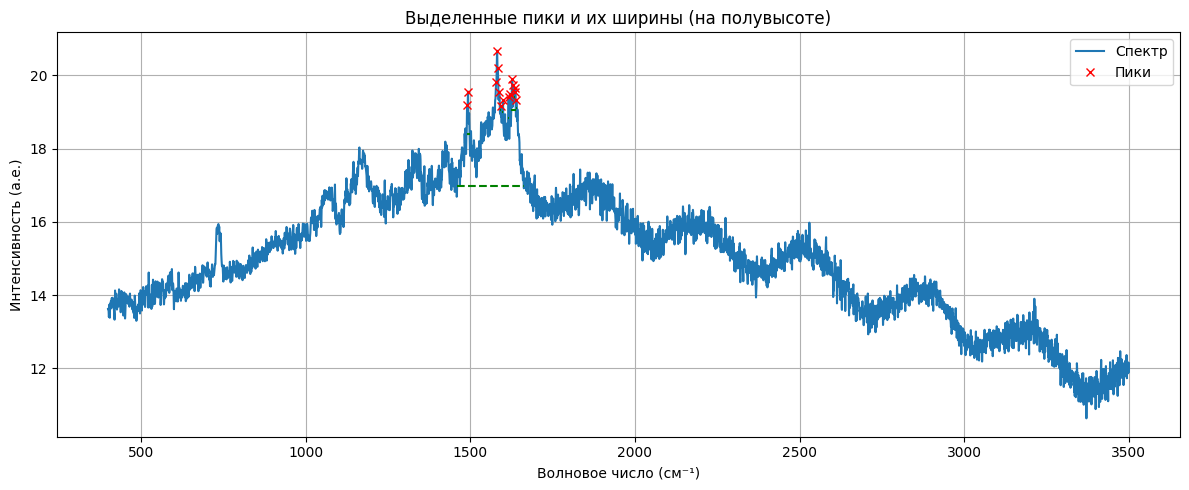

In [ ]:
# Пример для первого спектра (предположим, что у тебя уже есть X_interp и wavs):
spectrum_index = 0
plot_peaks(wavenumbers=wavs, intensity=X_interp[spectrum_index], min_prominence=0.001, top_n=15)


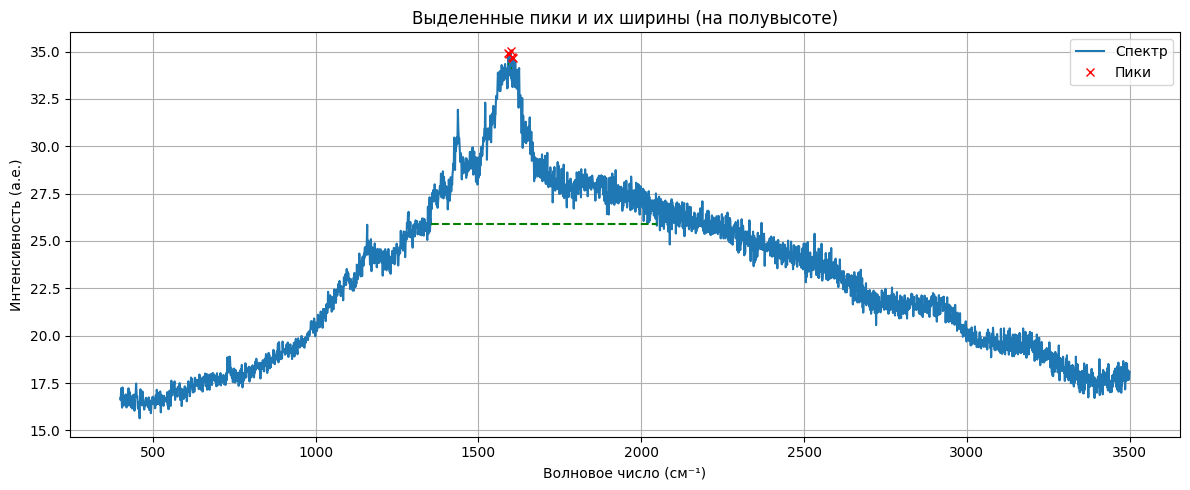

In [ ]:
# Пример для первого спектра (предположим, что у тебя уже есть X_interp и wavs):
spectrum_index = 1
plot_peaks(wavenumbers=wavs, intensity=X_interp[spectrum_index], min_prominence=0.01, top_n=5)


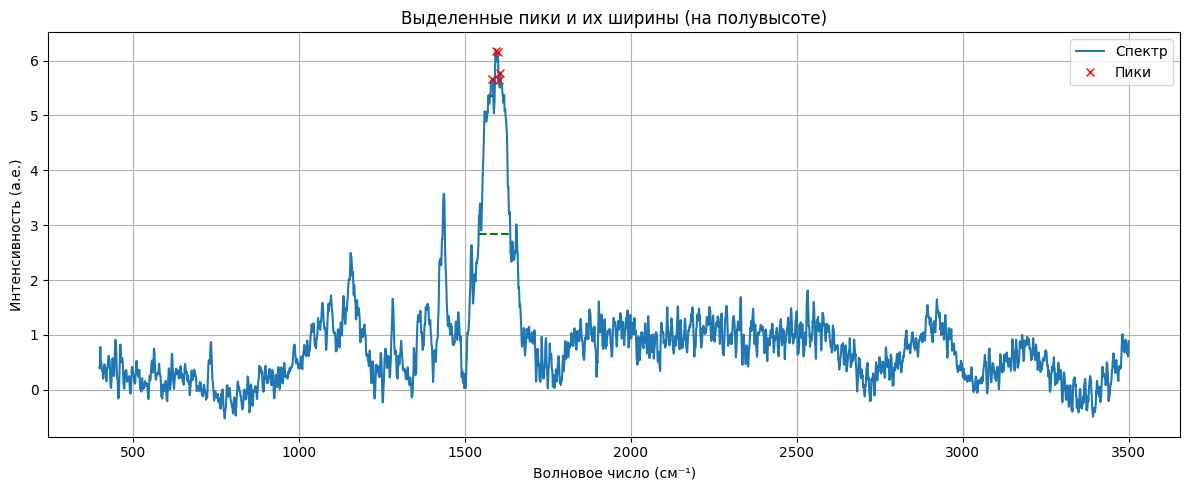

In [ ]:
# Пример для первого спектра (предположим, что у тебя уже есть X_interp и wavs):
spectrum_index = 2
plot_peaks(wavenumbers=wavs, intensity=X_interp[spectrum_index], min_prominence=0.01, top_n=5)


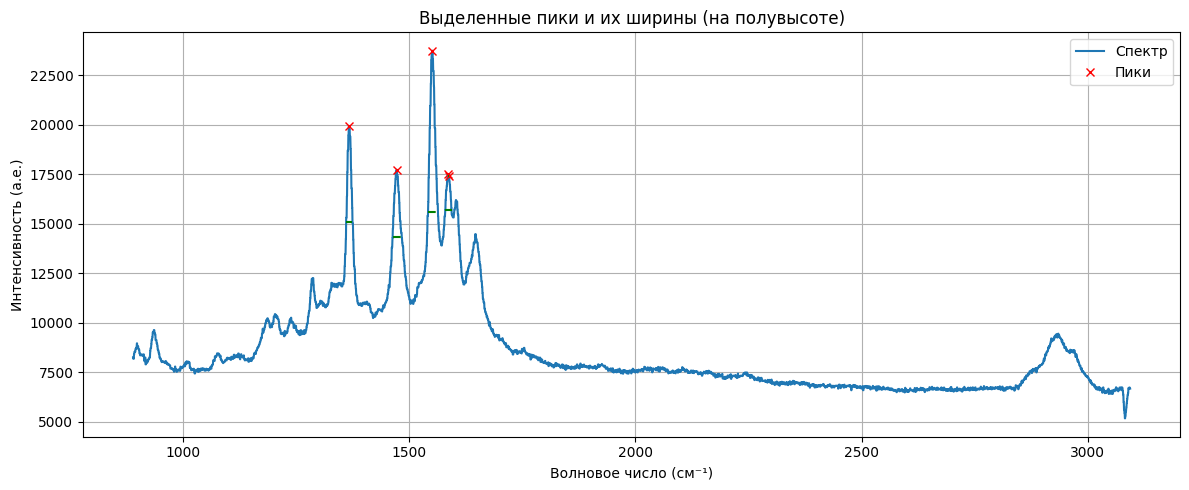

In [ ]:

# Пример для первого спектра (предположим, что у тебя уже есть X_interp и wavs):
spectrum_index = 6
plot_peaks(wavenumbers=wavs, intensity=X_interp[spectrum_index], min_prominence=0.01, top_n=5)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, peak_widths

def interpolate_common_grid(X_raw, y, wavs, step=1.0):
    def get_range(X, y, target_class, wavs):
        mask = y == target_class
        spectra_class = X[mask]
        not_nan_mask = ~np.isnan(spectra_class)
        has_data_mask = not_nan_mask.any(axis=0)
        return wavs[has_data_mask].min(), wavs[has_data_mask].max()

    range0 = get_range(X_raw, y, 0, wavs)
    range1 = get_range(X_raw, y, 1, wavs)
    common_start = max(range0[0], range1[0])
    common_end = min(range0[1], range1[1])
    common_wavs = np.arange(common_start, common_end + step, step)

    X_interp = []
    for xi in X_raw:
        mask = ~np.isnan(xi)
        if np.sum(mask) < 2:
            X_interp.append(np.zeros_like(common_wavs))
            continue
        f = interp1d(wavs[mask], xi[mask], kind='linear', bounds_error=False, fill_value=0)
        X_interp.append(f(common_wavs))
    return np.array(X_interp), common_wavs
def plot_peaks(wavenumbers, intensity, min_prominence=0.01, top_n=5):
    peaks, props = find_peaks(intensity, prominence=min_prominence)
    widths, width_heights, left_ips, right_ips = peak_widths(intensity, peaks, rel_height=0.5)

    # Выбираем top_n по высоте
    top_idxs = np.argsort(intensity[peaks])[-top_n:] if len(peaks) >= top_n else range(len(peaks))
    selected_peaks = peaks[top_idxs]

    # График
    plt.figure(figsize=(12, 5))
    plt.plot(wavenumbers, intensity, label='Интерполированный спектр')
    plt.plot(wavenumbers[selected_peaks], intensity[selected_peaks], "x", color='red', label='Пики')

    for i in top_idxs:
        center = wavenumbers[peaks[i]]
        width = right_ips[i] - left_ips[i]
        height = width_heights[i]
        plt.hlines(y=height, xmin=wavenumbers[int(left_ips[i])], xmax=wavenumbers[int(right_ips[i])],
                   color='green', linestyle='--', label='Ширина на полувысоте' if i == top_idxs[0] else None)

    plt.xlabel("Волновое число (см⁻¹)")
    plt.ylabel("Интенсивность (а.е.)")
    plt.title("Пики и ширины на полувысоте")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
# 1. Загрузка данных
df = pd.read_csv("restructured_dataset.csv")
meta_cols = {"Unnamed: 0", "spectrumID", "Class"}
wavs = np.array(sorted([float(c) for c in df.columns if c not in meta_cols]))
X_raw = df[[str(w) for w in wavs]].values
y = df["Class"].values

# 2. Интерполяция по общей сетке
X_interp, common_wavs = interpolate_common_grid(X_raw, y, wavs)


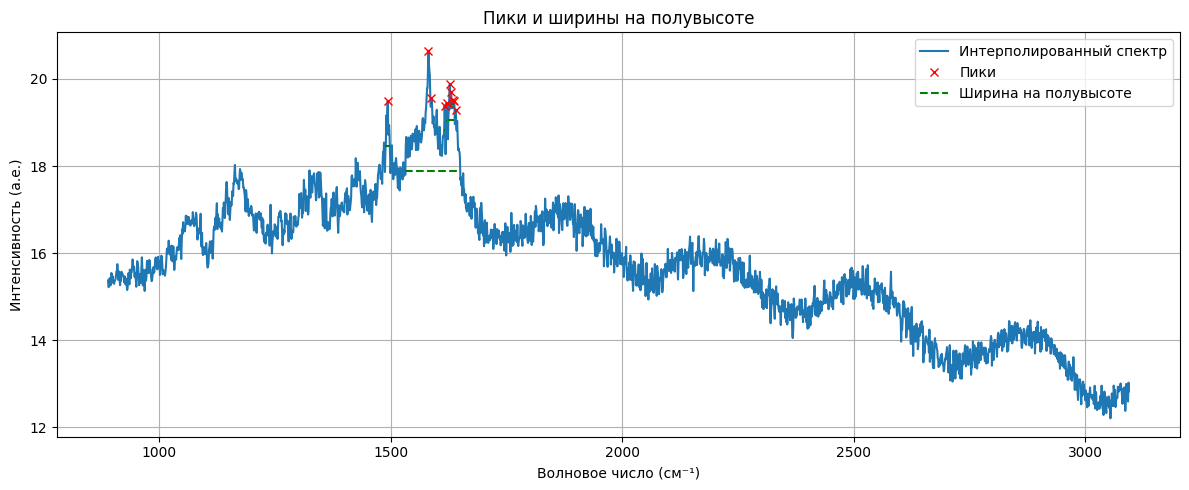

In [ ]:

# 3. Визуализация пиков для любого спектра
plot_peaks(common_wavs, X_interp[0], min_prominence=0.01, top_n=10)


In [ ]:

plot_peaks(common_wavs, X_interp[1], min_prominence=0.01, top_n=10)


In [ ]:
plot_peaks(common_wavs, X_interp[2], min_prominence=0.01, top_n=10)

In [ ]:
plot_peaks(common_wavs, X_interp[5], min_prominence=0.01, top_n=10)

In [ ]:

plot_peaks(common_wavs, X_interp[6], min_prominence=0.01, top_n=10)

In [ ]:

plot_peaks(common_wavs, X_interp[7], min_prominence=0.01, top_n=10)

NEED TO REMOVE ALUMINUM OUT OF DATASET

In [ ]:
rd = pd.read_csv("restructured_dataset.csv")

In [ ]:
df_clean = rd[~rd["spectrumID"].isin([3,4])].reset_index(drop=True)

In [ ]:
df_clean.loc[5,'spectrumID'] = 5
df_clean.loc[4,'spectrumID'] = 4
df_clean.loc[3, 'spectrumID'] = 3

In [ ]:
df_clean.to_csv("FINAL.csv")

In [ ]:
df_clean

,spectrumID,99.76147,100.2436,100.7257,101.2078,101.6899,102.1721,102.6542,103.1363,103.6184,...,3496.273,3496.756,3497.238,3497.72,3498.202,3498.684,3499.166,3499.648,3500.13,Class
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.860640,11.923890,12.115200,12.163440,12.071620,11.882160,11.922870,12.065420,12.133940,0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.001020,17.662610,17.976970,18.014010,17.856410,17.690950,17.856570,18.079690,18.099250,0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.654684,0.675116,0.662451,0.651077,0.629126,0.608711,0.643103,0.799446,0.886864,0
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


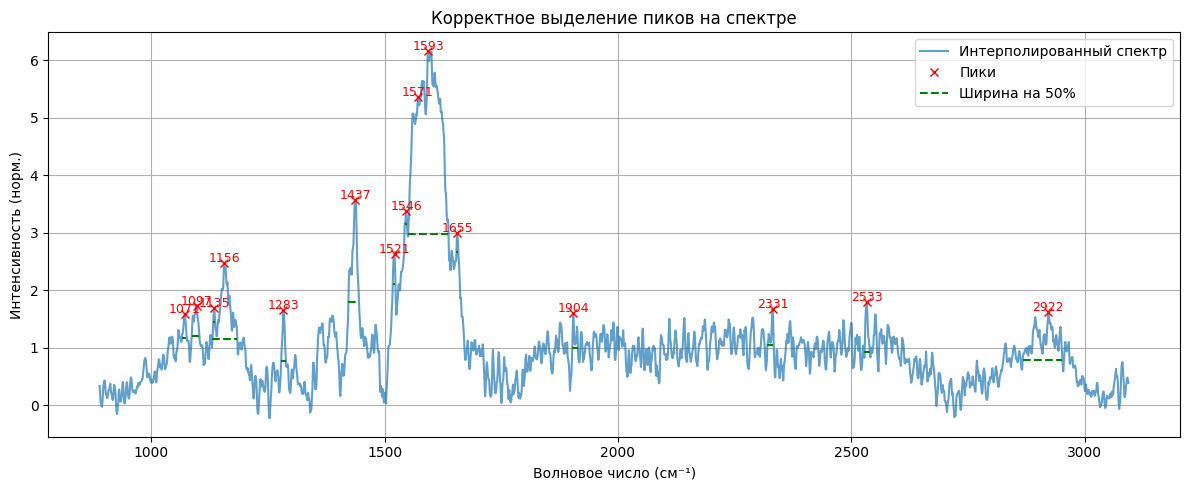

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

def plot_adjusted_peaks(wavenumbers, intensity, top_n=5, min_prominence=0.02, min_distance=5):
    """
    Ищет и отображает top-N пиков на интерполированном спектре.
    
    Параметры:
        wavenumbers     — массив волновых чисел (равномерных!)
        intensity       — спектр (интенсивности)
        top_n           — сколько пиков отобразить
        min_prominence  — минимальная «заметность» пика (по высоте над фоном)
        min_distance    — минимальное расстояние между пиками (в точках)
    """

    # Ищем пики
    peaks, properties = find_peaks(
        intensity,
        prominence=min_prominence,
        distance=min_distance
    )

    # Если пиков мало — берём все; иначе берём top-N по высоте
    if len(peaks) > top_n:
        top_idxs = np.argsort(intensity[peaks])[-top_n:]
        peaks = peaks[top_idxs]

    # Ширина пиков (на 50% высоты)
    results_half = peak_widths(intensity, peaks, rel_height=0.5)




    # Построение графика
    plt.figure(figsize=(12, 5))
    plt.plot(wavenumbers, intensity, label="Интерполированный спектр", alpha=0.7)
    plt.plot(wavenumbers[peaks], intensity[peaks], "x", color="red", label="Пики")

    # Отметка ширины пиков
    for i in range(len(peaks)):
        left = int(results_half[2][i])
        right = int(results_half[3][i])
        height = results_half[1][i]
        plt.hlines(height, wavenumbers[left], wavenumbers[right],
                   color="green", linestyle="--", label="Ширина на 50%" if i == 0 else None)

    # Подписи
    for i, peak in enumerate(peaks):
        wn = wavenumbers[peak]
        amp = intensity[peak]
        plt.text(wn, amp + 0.02, f"{wn:.0f}", ha="center", fontsize=9, color="red")

    plt.xlabel("Волновое число (см⁻¹)")
    plt.ylabel("Интенсивность (норм.)")
    plt.title("Корректное выделение пиков на спектре")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
# Пример: отобразить 6 самых заметных пиков для спектра 0
plot_adjusted_peaks(
    wavenumbers=common_wavs,
    intensity=X_interp[2],
    top_n=15,
    min_prominence=0.1,
    min_distance=20  # можно варьировать
)




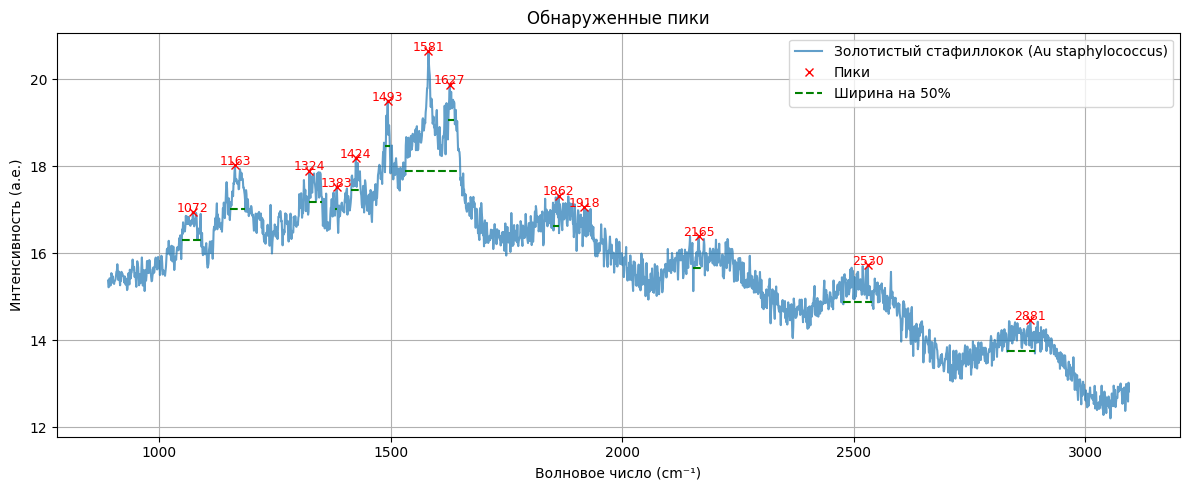

In [ ]:
import matplotlib.pyplot as plt
def find_peaks_physical(wavenumbers, intensity, min_prominence=0.01, min_distance_cm=15, top_n=5):
    """
    Находит пики с минимальной дистанцией по физическому расстоянию (в см⁻¹),
    а не по индексам.
    """
    step = np.median(np.diff(wavenumbers))  # предполагаем равномерную сетку
    index_distance = int(min_distance_cm / step)

    peaks, props = find_peaks(
        intensity,
        prominence=min_prominence,
        distance=index_distance
    )

    if len(peaks) > top_n:
        top_idxs = np.argsort(intensity[peaks])[-top_n:]
        peaks = peaks[top_idxs]

    return peaks, props

def plot_physical_peaks(wavenumbers, intensity, min_prominence=0.01, min_distance_cm=15, top_n=5):
    # Use the custom peak finder
    peaks, props = find_peaks_physical(
        wavenumbers, intensity,
        min_prominence=min_prominence,
        min_distance_cm=min_distance_cm,
        top_n=top_n
    )

    # Plot spectrum
    plt.figure(figsize=(12, 5))
    plt.plot(wavenumbers, intensity, label="Золотистый стафиллокок (Au staphylococcus)", alpha=0.7)

    # Plot peaks
    plt.plot(wavenumbers[peaks], intensity[peaks], "rx", label="Пики")
    for i, peak in enumerate(peaks):
        wn = wavenumbers[peak]
        amp = intensity[peak]
        plt.text(wn, amp + 0.01, f"{wn:.0f}", ha="center", fontsize=9, color="red")

    # Отметка ширины пиков
    results_half = peak_widths(intensity, peaks, rel_height=0.5)
    for i in range(len(peaks)):
        left = int(results_half[2][i])
        right = int(results_half[3][i])
        height = results_half[1][i]
        plt.hlines(height, wavenumbers[left], wavenumbers[right],
                   color="green", linestyle="--", label="Ширина на 50%" if i == 0 else None)

    plt.xlabel("Волновое число (cm⁻¹)")
    plt.ylabel("Интенсивность (а.е.)")
    plt.title("Обнаруженные пики")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_physical_peaks(
    wavenumbers=common_wavs,
    intensity=X_interp[0],
    min_prominence=1,
    min_distance_cm=40,
    top_n=15
)



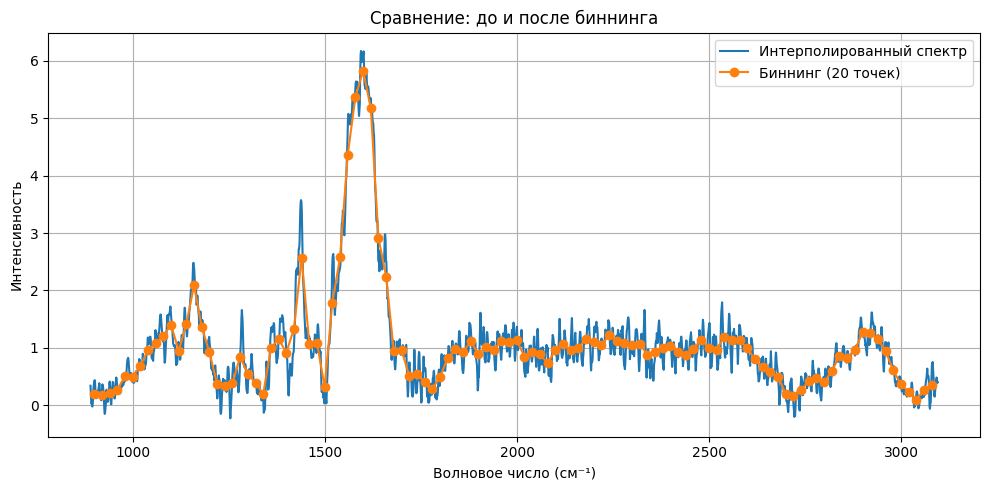

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Повторная загрузка и интерполяция (сброшена среда)
df = pd.read_csv("restructured_dataset.csv")
meta_cols = {"Unnamed: 0", "spectrumID", "Class"}
wavs = np.array(sorted([float(c) for c in df.columns if c not in meta_cols]))
X_raw = df[[str(w) for w in wavs]].values
y = df["Class"].values

def interpolate_common_grid(X_raw, y, wavs, step=1.0):
    def get_range(X, y, cls):
        mask = y == cls
        data = X[mask]
        notnan = ~np.isnan(data)
        valid = notnan.any(axis=0)
        return wavs[valid].min(), wavs[valid].max()
    r0 = get_range(X_raw, y, 0)
    r1 = get_range(X_raw, y, 1)
    start, end = max(r0[0], r1[0]), min(r0[1], r1[1])
    common_wavs = np.arange(start, end + step, step)
    X_interp = []
    for row in X_raw:
        mask = ~np.isnan(row)
        f = interp1d(wavs[mask], row[mask], kind='nearest', bounds_error=False, fill_value=0)
        X_interp.append(f(common_wavs))
    return np.array(X_interp), common_wavs

X_interp, common_wavs = interpolate_common_grid(X_raw, y, wavs)

# Применение биннинга
bin_size = 20
n_bins = len(common_wavs) // bin_size
binned_wavs = [common_wavs[i*bin_size:(i+1)*bin_size].mean() for i in range(n_bins)]
binned_intensity = [X_interp[2][i*bin_size:(i+1)*bin_size].mean() for i in range(n_bins)]

# График
plt.figure(figsize=(10, 5))
plt.plot(common_wavs, X_interp[2], label="Интерполированный спектр")
plt.plot(binned_wavs, binned_intensity, label="Биннинг (20 точек)", marker='o')
plt.xlabel("Волновое число (см⁻¹)")
plt.ylabel("Интенсивность")
plt.title("Сравнение: до и после биннинга")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_widths
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import Normalizer

# 1. Load data
df = pd.read_csv("FINAL.csv")
meta_cols = {"Unnamed: 0", "spectrumID", "Class"}
wavs = np.array(sorted([float(c) for c in df.columns if c not in meta_cols]))
X_raw = df[[str(w) for w in wavs]].values
y = df["Class"].values
groups = df["spectrumID"].values

# 2. Interpolate to common grid
def interpolate_common_grid(X_raw, y, wavs, step=1.0):
    def get_range(X, y, cls):
        mask = y == cls
        data = X[mask]
        notnan = ~np.isnan(data)
        valid = notnan.any(axis=0)
        return wavs[valid].min(), wavs[valid].max()
    r0 = get_range(X_raw, y, 0)
    r1 = get_range(X_raw, y, 1)
    start, end = max(r0[0], r1[0]), min(r0[1], r1[1])
    common_wavs = np.arange(start, end + step, step)
    X_interp = np.array([
        interp1d(wavs[~np.isnan(x)], x[~np.isnan(x)], kind='nearest', bounds_error=False, fill_value=0)(common_wavs)
        for x in X_raw
    ])
    return X_interp, common_wavs

X_interp, common_wavs = interpolate_common_grid(X_raw, y, wavs)

# 3. Binning
bin_size = 5
n_bins = len(common_wavs) // bin_size
binned_wavs = np.array([common_wavs[i*bin_size:(i+1)*bin_size].mean() for i in range(n_bins)])
X_binned = np.array([
    np.array([row[i*bin_size:(i+1)*bin_size].mean() for i in range(n_bins)])
    for row in X_interp
])

# 4. Peak extraction on binned data
def extract_peak_features_binned(X, wvs, top_n=5, min_prominence=0.02, min_distance_cm=15):
    step = np.median(np.diff(wvs))
    index_distance = int(min_distance_cm / step)
    features = []
    for xi in X:
        peaks, props = find_peaks(xi, prominence=min_prominence, distance=index_distance)
        heights = xi[peaks]
        positions = wvs[peaks]
        widths, *_ = peak_widths(xi, peaks, rel_height=0.5)
        # select top_n by height
        if len(peaks) >= top_n:
            idxs = np.argsort(heights)[-top_n:]
        else:
            idxs = np.arange(len(peaks))
        feat = []
        for i in idxs[::-1]:
            feat.extend([positions[i], heights[i], widths[i]])
        # pad
        while len(feat) < top_n*3:
            feat.extend([0,0,0])
        features.append(feat)
    return np.array(features)

X_features = extract_peak_features_binned(X_binned, binned_wavs, top_n=5)



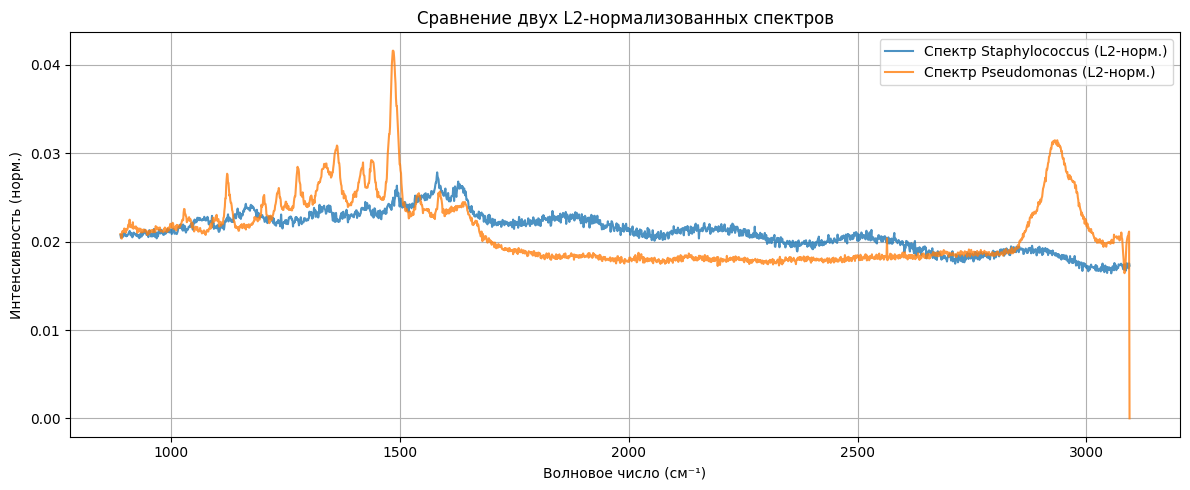

In [ ]:
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt

# Выбираем два спектра по индексам
i1, i2 = 0, 3
spec1 = X_interp[i1].reshape(1, -1)
spec2 = X_interp[i2].reshape(1, -1)

# Нормализация
norm = Normalizer(norm='l2')
spec1_norm = norm.transform(spec1).flatten()
spec2_norm = norm.transform(spec2).flatten()

# Построение
plt.figure(figsize=(12, 5))
plt.plot(common_wavs, spec1_norm, label=f"Спектр Staphylococcus (L2-норм.)", alpha=0.8)
plt.plot(common_wavs, spec2_norm, label=f"Спектр Pseudomonas (L2-норм.)", alpha=0.8)
plt.title("Сравнение двух L2-нормализованных спектров")
plt.xlabel("Волновое число (см⁻¹)")
plt.ylabel("Интенсивность (норм.)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, peak_widths
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Load and interpolate data
df = pd.read_csv("FINAL.csv")
meta = {"Unnamed: 0", "spectrumID", "Class"}
wavs = np.array(sorted([float(c) for c in df.columns if c not in meta]))
X_raw = df[[str(w) for w in wavs]].values
y = df["Class"].values

def interp_common(X_raw, y, wavs):
    def get_range(X, y, cls):
        m = y == cls
        d = X[m]
        valid = (~np.isnan(d)).any(axis=0)
        return wavs[valid].min(), wavs[valid].max()
    r0, r1 = get_range(X_raw, y, 0), get_range(X_raw, y, 1)
    start, end = max(r0[0], r1[0]), min(r0[1], r1[1])
    grid = np.arange(start, end+1, 1.0)
    Xi = np.array([ interp1d(wavs[~np.isnan(x)], x[~np.isnan(x)], 
                             kind='nearest', bounds_error=False, fill_value=0)(grid)
                    for x in X_raw ])
    return Xi, grid

X_interp, common_wavs = interp_common(X_raw, y, wavs)

# 2. Split: 2 train per class, rest test
train_idx = np.concatenate([
    np.where(y==0)[0][2:3],
    np.where(y==1)[0][2:3]
])
test_idx = np.setdiff1d(np.arange(len(y)), train_idx)

X_train, y_train = X_interp[train_idx], y[train_idx]
X_test, y_test = X_interp[test_idx], y[test_idx]

# 3. Feature extraction: simple L2-normalized raw spectra
norm = Normalizer(norm='l2')
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)

# 4. Train and evaluate
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_norm, y_train)
y_pred = clf.predict(X_test_norm)

acc = accuracy_score(y_test, y_pred)
print("Train indices:", train_idx)
print("Test indices: ", test_idx)
print("Test accuracy:", acc)


Train indices: [2 5]
Test indices:  [0 1 3 4]
Test accuracy: 0.5


In [ ]:
# Функция для извлечения признаков пиков из спектров
def extract_peak_features(X, wvs, top_n=5, min_prominence=0.02, min_distance_cm=15):
    step = np.median(np.diff(wvs))
    index_distance = int(min_distance_cm / step)
    features = []
    for xi in X:
        peaks, _ = find_peaks(xi, prominence=min_prominence, distance=index_distance)
        heights = xi[peaks]
        positions = wvs[peaks]
        widths, *_ = peak_widths(xi, peaks, rel_height=0.5)
        if len(peaks) >= top_n:
            idxs = np.argsort(heights)[-top_n:]
        else:
            idxs = np.arange(len(peaks))
        feat = []
        for i in idxs[::-1]:  # от самых высоких
            feat.extend([positions[i], heights[i], widths[i]])
        while len(feat) < top_n * 3:
            feat.extend([0, 0, 0])
        features.append(feat)
    return np.array(features)

# Извлечение признаков пиков
X_train_feat = extract_peak_features(X_train_norm, common_wavs, top_n=5)
X_test_feat = extract_peak_features(X_test_norm, common_wavs, top_n=5)

# Обучение и оценка
clf_peak = RandomForestClassifier(n_estimators=100, random_state=42)
clf_peak.fit(X_train_feat, y_train)
y_pred_peak = clf_peak.predict(X_test_feat)
acc_peak = accuracy_score(y_test, y_pred_peak)
print(train_idx)
acc_peak


[2 5]


0.5

In [3]:
# Повторная загрузка и подготовка данных после сброса окружения
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
from scipy.interpolate import interp1d

# Загрузка данных
df = pd.read_csv("FINAL.csv")
df

,Unnamed: 0,spectrumID,400.1202,400.6023,401.0844,401.5665,402.0486,402.5308,403.0129,403.495,...,3496.273,3496.756,3497.238,3497.72,3498.202,3498.684,3499.166,3499.648,3500.13,Class
0,0,0,13.623470,13.608400,13.633900,13.612130,13.49463,13.405410,13.443150,13.670980,...,11.860640,11.923890,12.115200,12.163440,12.071620,11.882160,11.922870,12.065420,12.133940,0
1,1,1,16.702800,16.597580,16.741700,16.890020,17.09677,17.224010,17.167970,16.870630,...,18.001020,17.662610,17.976970,18.014010,17.856410,17.690950,17.856570,18.079690,18.099250,0
2,2,2,0.412945,0.391413,0.427336,0.615879,0.77862,0.776802,0.591732,0.470215,...,0.654684,0.675116,0.662451,0.651077,0.629126,0.608711,0.643103,0.799446,0.886864,0
3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


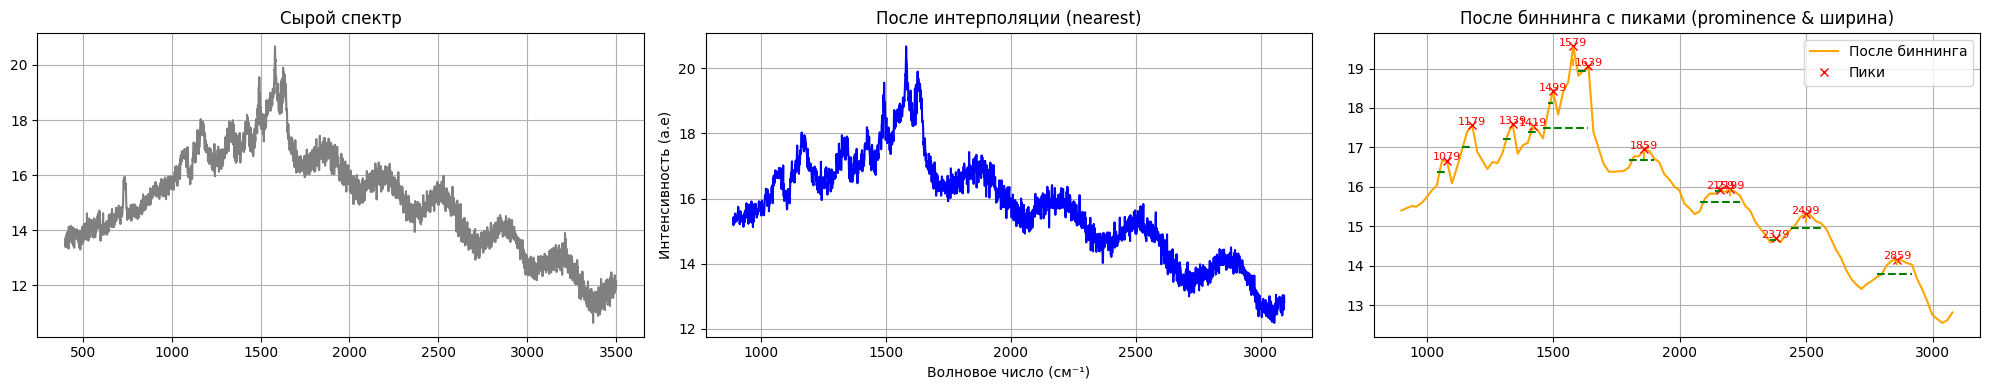

In [20]:

meta_cols = {"Unnamed: 0", "spectrumID", "Class"}
wavs = np.array(sorted([float(c) for c in df.columns if c not in meta_cols]))
X_raw = df[[str(w) for w in wavs]].values
y = df["Class"].values

# Интерполяция
def interpolate_common_grid(X_raw, y, wavs, step=1.0):
    def get_range(X, y, cls):
        mask = y == cls
        data = X[mask]
        notnan = ~np.isnan(data)
        valid = notnan.any(axis=0)
        return wavs[valid].min(), wavs[valid].max()
    r0 = get_range(X_raw, y, 0)
    r1 = get_range(X_raw, y, 1)
    start, end = max(r0[0], r1[0]), min(r0[1], r1[1])
    common_wavs = np.arange(start, end + step, step)
    X_interp = np.array([
        interp1d(wavs[~np.isnan(x)], x[~np.isnan(x)], kind='nearest', bounds_error=False, fill_value=0)(common_wavs)
        for x in X_raw
    ])
    return X_interp, common_wavs

X_interp, common_wavs = interpolate_common_grid(X_raw, y, wavs)

# Визуализация разных стадий предобработки
idx = 0
spectrum_raw = X_raw[idx]
spectrum_interp = X_interp[idx]
wavs_raw = wavs[~np.isnan(spectrum_raw)]
intens_raw = spectrum_raw[~np.isnan(spectrum_raw)]

bin_size = 20

n_bins = len(common_wavs) // bin_size
binned_wavs = np.array([common_wavs[i*bin_size:(i+1)*bin_size].mean() for i in range(n_bins)])
binned_intensity = np.array([
    spectrum_interp[i*bin_size:(i+1)*bin_size].mean() for i in range(n_bins)
])

peaks, _ = find_peaks(binned_intensity, prominence=0.05, distance=2)
widths, width_heights, left_ips, right_ips = peak_widths(binned_intensity, peaks, rel_height=0.5)

fig, axs = plt.subplots(1, 3, figsize=(20, 4))
axs[0].plot(wavs_raw, intens_raw, label="Сырой спектр", color="gray")
axs[0].set_title("Сырой спектр")
axs[0].grid(True)

axs[1].plot(common_wavs, spectrum_interp, label="Интерполированный", color="blue")
axs[1].set_title("После интерполяции (nearest)")
axs[1].grid(True)

axs[2].plot(binned_wavs, binned_intensity, label="После биннинга", color="orange")
axs[2].plot(binned_wavs[peaks], binned_intensity[peaks], "rx", label="Пики")
for i, peak in enumerate(peaks):
    left = int(left_ips[i])
    right = int(right_ips[i])
    height = width_heights[i]
    base = max(binned_intensity[left], binned_intensity[right])
    axs[2].vlines(binned_wavs[peak], base, binned_intensity[peak], color="orange", linestyle="--")
    axs[2].hlines(height, binned_wavs[left], binned_wavs[right], color="green", linestyle="--")
    axs[2].text(binned_wavs[peak], binned_intensity[peak]+0.01, f"{binned_wavs[peak]:.0f}", ha='center', fontsize=8, color="red")

axs[2].set_title("После биннинга с пиками (prominence & ширина)")
axs[2].legend()
axs[2].grid(True)
axs[1].set_xlabel("Волновое число (см⁻¹)")
axs[1].set_ylabel("Интенсивность (а.е)")
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_widths
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import Normalizer

# 1. Load data
df = pd.read_csv("FINAL.csv")
meta_cols = {"Unnamed: 0", "spectrumID", "Class"}
wavs = np.array(sorted([float(c) for c in df.columns if c not in meta_cols]))
X_raw = df[[str(w) for w in wavs]].values
y = df["Class"].values
groups = df["spectrumID"].values

# 2. Interpolate to common grid
def interpolate_common_grid(X_raw, y, wavs, step=2.0):
    def get_range(X, y, cls):
        mask = y == cls
        data = X[mask]
        notnan = ~np.isnan(data)
        valid = notnan.any(axis=0)
        return wavs[valid].min(), wavs[valid].max()
    r0 = get_range(X_raw, y, 0)
    r1 = get_range(X_raw, y, 1)
    start, end = max(r0[0], r1[0]), min(r0[1], r1[1])
    common_wavs = np.arange(start, end + step, step)
    X_interp = np.array([
        interp1d(wavs[~np.isnan(x)], x[~np.isnan(x)], kind='nearest', bounds_error=False, fill_value=0)(common_wavs)
        for x in X_raw
    ])
    return X_interp, common_wavs

X_interp, common_wavs = interpolate_common_grid(X_raw, y, wavs)

# 3. Binning
bin_size = 5
n_bins = len(common_wavs) // bin_size
binned_wavs = np.array([common_wavs[i*bin_size:(i+1)*bin_size].mean() for i in range(n_bins)])
X_binned = np.array([
    np.array([row[i*bin_size:(i+1)*bin_size].mean() for i in range(n_bins)])
    for row in X_interp
])

# 4. Peak extraction on binned data
def extract_peak_features_binned(X, wvs, top_n=5, min_prominence=0.02, min_distance_cm=15):
    step = np.median(np.diff(wvs))
    index_distance = int(min_distance_cm / step)
    features = []
    for xi in X:
        peaks, props = find_peaks(xi, prominence=min_prominence, distance=index_distance)
        heights = xi[peaks]
        positions = wvs[peaks]
        widths, *_ = peak_widths(xi, peaks, rel_height=0.5)
        # select top_n by height
        if len(peaks) >= top_n:
            idxs = np.argsort(heights)[-top_n:]
        else:
            idxs = np.arange(len(peaks))
        feat = []
        for i in idxs[::-1]:
            feat.extend([positions[i], heights[i], widths[i]])
        # pad
        while len(feat) < top_n*3:
            feat.extend([0,0,0])
        features.append(feat)
    return np.array(features)

X_features = extract_peak_features_binned(X_binned, binned_wavs, top_n=5)

# 5. Normalize features
X_norm = Normalizer(norm='l2').fit_transform(X_features)

# 6. Train and evaluate with LOSO
clf = RandomForestClassifier(n_estimators=100, random_state=42)
cv = GroupKFold(n_splits=len(np.unique(groups)))
scores = cross_val_score(clf, X_norm, y, groups=groups, cv=cv, scoring='balanced_accuracy')
print("LOSO balanced accuracy on peak features:", np.round(scores,3))
print("Mean:", np.round(scores.mean(),3))


/home/sapar/Scripts/Conference/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/sapar/Scripts/Conference/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/sapar/Scripts/Conference/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/sapar/Scripts/Conference/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A sin

LOSO balanced accuracy on peak features: [1. 1. 1. 1. 1. 1.]
Mean: 1.0


/home/sapar/Scripts/Conference/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/sapar/Scripts/Conference/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


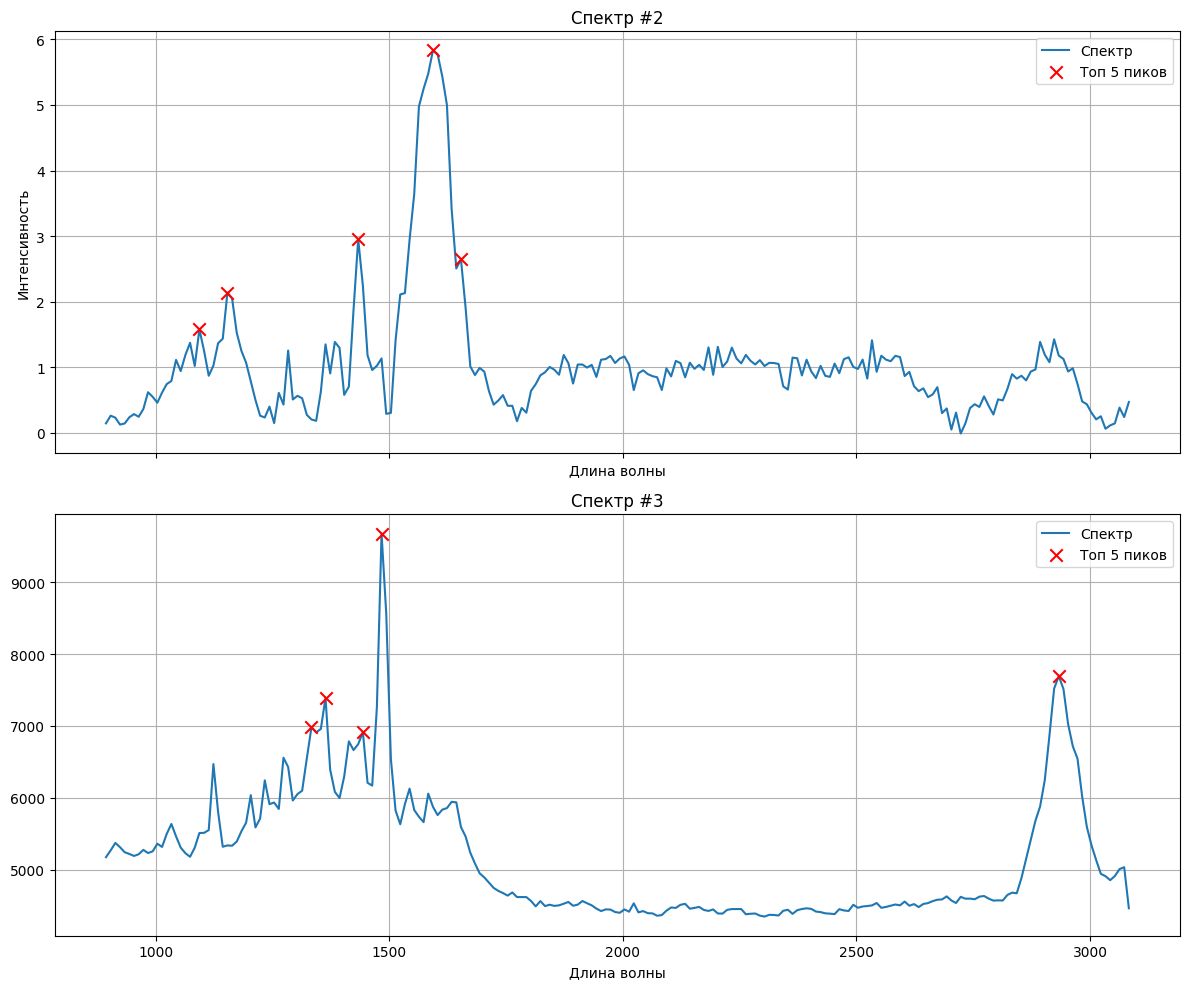

In [80]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import numpy as np

# спектры для показа
i1, i2 = 2, 3

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for ax, i in zip(axes, [i1, i2]):
    xi = X_binned[i]
    peaks, props = find_peaks(
        xi,
        prominence=0.02,
        distance=int(15 / np.median(np.diff(binned_wavs)))
    )
    
    # выбираем top 5 пиков по высоте
    heights = xi[peaks]
    if len(peaks) > 5:
        top_idx = np.argsort(heights)[-5:]  # индексы 5 самых высоких пиков
        peaks = peaks[top_idx]
        heights = heights[top_idx]

    # пересчитываем ширины только для top 5
    widths, width_heights, *_ = peak_widths(xi, peaks, rel_height=0.5)

    # рисуем спектр
    ax.plot(binned_wavs, xi, label='Спектр')
    ax.scatter(binned_wavs[peaks], heights,
               marker='x', s=80, label='Топ 5 пиков', zorder=3,color="red")



    ax.set_title(f'Спектр #{i}')
    ax.set_xlabel('Длина волны')
    ax.legend()
    ax.grid(True)

axes[0].set_ylabel('Интенсивность')
plt.tight_layout()
plt.show()


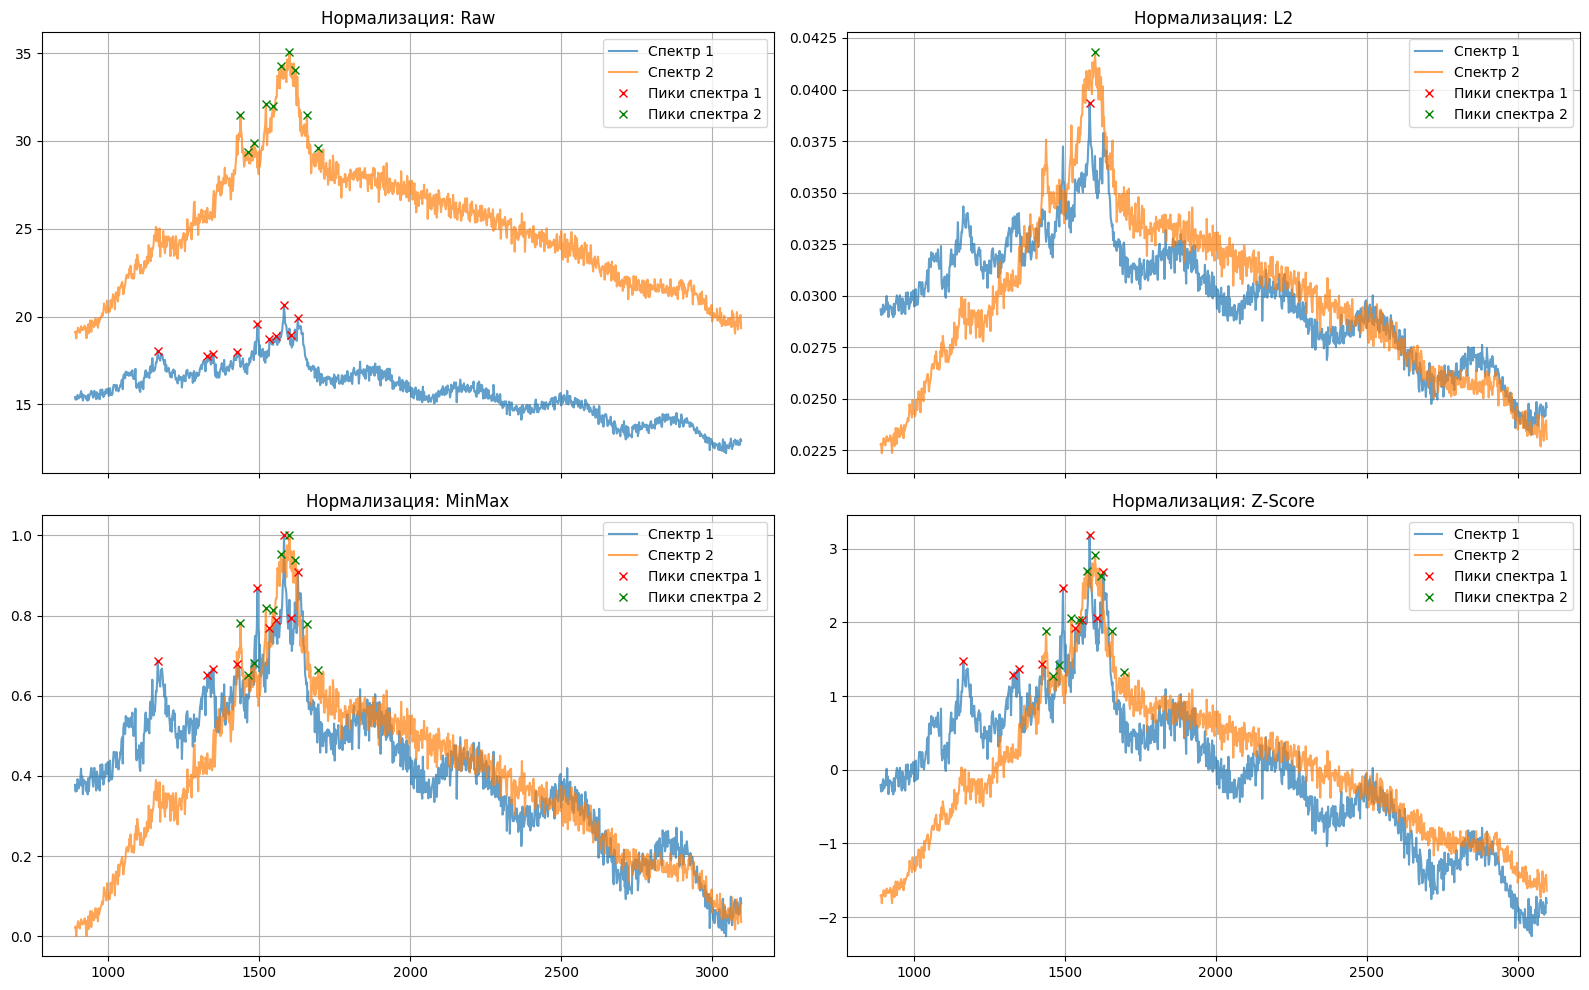

In [82]:
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler

# Возьмем два спектра с разными масштабами
spec1 = X_interp[0]         # обычный
spec2 = X_interp[1]   # искусственно увеличим масштаб второго

# Нормализация разными способами
methods = {
    'Raw': (spec1, spec2),
    'L2': (
        Normalizer(norm='l2').fit_transform(spec1.reshape(1, -1)).flatten(),
        Normalizer(norm='l2').fit_transform(spec2.reshape(1, -1)).flatten()
    ),
    'MinMax': (
        MinMaxScaler().fit_transform(spec1.reshape(-1, 1)).flatten(),
        MinMaxScaler().fit_transform(spec2.reshape(-1, 1)).flatten()
    ),
    'Z-Score': (
        StandardScaler().fit_transform(spec1.reshape(-1, 1)).flatten(),
        StandardScaler().fit_transform(spec2.reshape(-1, 1)).flatten()
    )
}

# Функция поиска топ-10 пиков
def get_top_peaks(spectrum, wvs, top_n=10, prominence=0.01, distance=10):
    peaks, _ = find_peaks(spectrum, prominence=prominence, distance=distance)
    if len(peaks) > top_n:
        peaks = peaks[np.argsort(spectrum[peaks])[-top_n:]]
    return peaks, spectrum[peaks]

# Визуализация для каждой нормализации
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

for ax, (label, (s1, s2)) in zip(axs.flatten(), methods.items()):
    p1, _ = get_top_peaks(s1, common_wavs)
    p2, _ = get_top_peaks(s2, common_wavs)
    
    ax.plot(common_wavs, s1, label="Спектр 1", alpha=0.7)
    ax.plot(common_wavs, s2, label="Спектр 2", alpha=0.7)
    ax.plot(common_wavs[p1], s1[p1], "rx", label="Пики спектра 1")
    ax.plot(common_wavs[p2], s2[p2], "gx", label="Пики спектра 2")
    ax.set_title(f"Нормализация: {label}")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


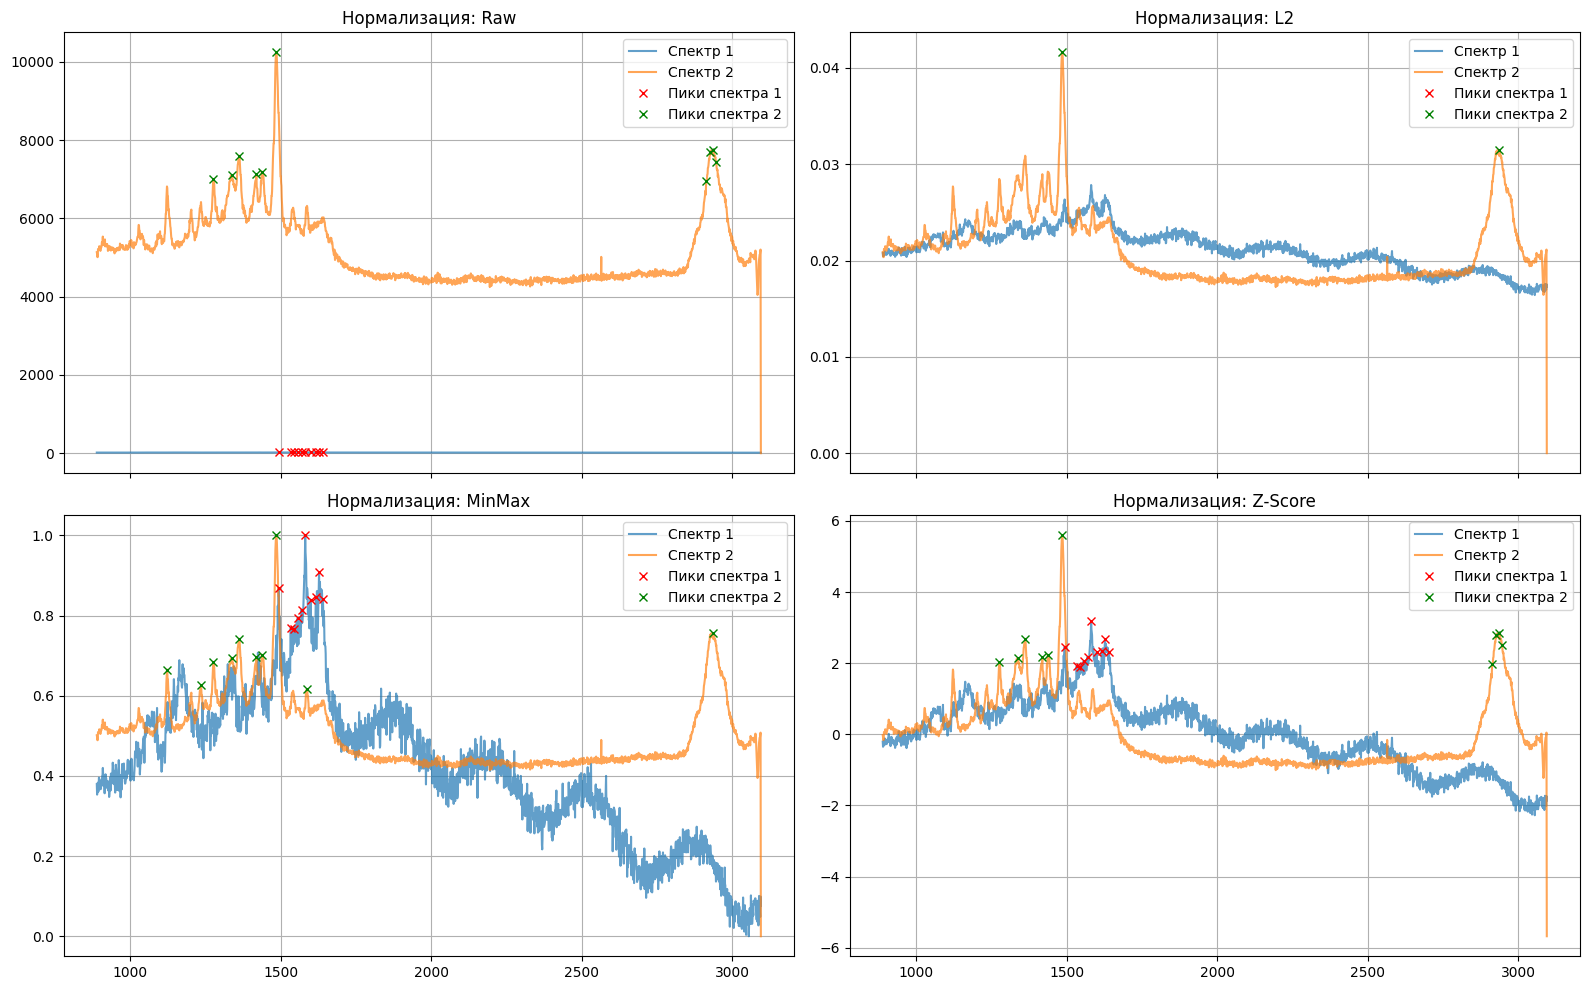

In [86]:
# Перезагрузка данных и библиотек после сброса окружения
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler

# Загрузка данных
df = pd.read_csv("FINAL.csv")
meta_cols = {"Unnamed: 0", "spectrumID", "Class"}
wavs = np.array(sorted([float(c) for c in df.columns if c not in meta_cols]))
X_raw = df[[str(w) for w in wavs]].values
y = df["Class"].values

# Интерполяция
def interpolate_common_grid(X_raw, y, wavs, step=1.0):
    def get_range(X, y, cls):
        m = y == cls
        d = X[m]
        valid = (~np.isnan(d)).any(axis=0)
        return wavs[valid].min(), wavs[valid].max()
    r0, r1 = get_range(X_raw, y, 0), get_range(X_raw, y, 1)
    start, end = max(r0[0], r1[0]), min(r0[1], r1[1])
    grid = np.arange(start, end + step, step)
    X_interp = np.array([
        interp1d(wavs[~np.isnan(x)], x[~np.isnan(x)], kind='nearest', bounds_error=False, fill_value=0)(grid)
        for x in X_raw
    ])
    return X_interp, grid

X_interp, common_wavs = interpolate_common_grid(X_raw, y, wavs)

# Спектры для анализа
spec1 = X_interp[0]
spec2 = X_interp[3]  # искусственное усиление

# Методы нормализации
methods = {
    'Raw': (spec1, spec2),
    'L2': (
        Normalizer(norm='l2').fit_transform(spec1.reshape(1, -1)).flatten(),
        Normalizer(norm='l2').fit_transform(spec2.reshape(1, -1)).flatten()
    ),
    'MinMax': (
        MinMaxScaler().fit_transform(spec1.reshape(-1, 1)).flatten(),
        MinMaxScaler().fit_transform(spec2.reshape(-1, 1)).flatten()
    ),
    'Z-Score': (
        StandardScaler().fit_transform(spec1.reshape(-1, 1)).flatten(),
        StandardScaler().fit_transform(spec2.reshape(-1, 1)).flatten()
    )
}

# Функция поиска пиков
def get_top_peaks(spectrum, wvs, top_n=10, prominence=0.01, distance=10):
    peaks, _ = find_peaks(spectrum, prominence=prominence, distance=distance)
    if len(peaks) > top_n:
        peaks = peaks[np.argsort(spectrum[peaks])[-top_n:]]
    return peaks, spectrum[peaks]

# Построение графиков
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

for ax, (label, (s1, s2)) in zip(axs.flatten(), methods.items()):
    p1, _ = get_top_peaks(s1, common_wavs)
    p2, _ = get_top_peaks(s2, common_wavs)
    ax.plot(common_wavs, s1, label="Спектр 1", alpha=0.7)
    ax.plot(common_wavs, s2, label="Спектр 2", alpha=0.7)
    ax.plot(common_wavs[p1], s1[p1], "rx", label="Пики спектра 1")
    ax.plot(common_wavs[p2], s2[p2], "gx", label="Пики спектра 2")
    ax.set_title(f"Нормализация: {label}")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


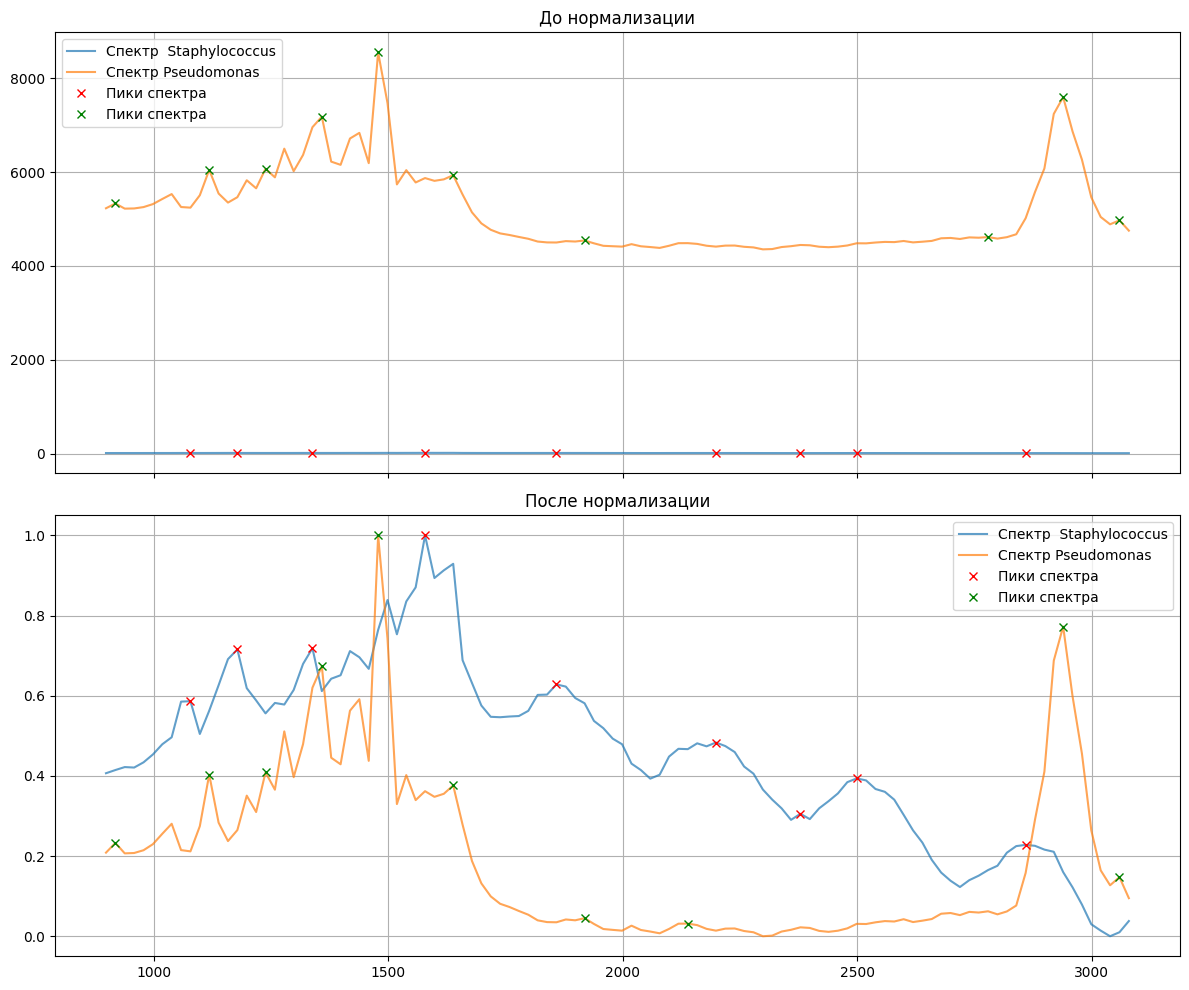

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler

# Биннинг
def apply_binning(spectrum, wavenumbers, bin_size=20):
    n_bins = len(wavenumbers) // bin_size
    binned_wavs = np.array([wavenumbers[i*bin_size:(i+1)*bin_size].mean() for i in range(n_bins)])
    binned_intensity = np.array([
        spectrum[i*bin_size:(i+1)*bin_size].mean() for i in range(n_bins)
    ])
    return binned_wavs, binned_intensity

# Поиск пиков
def get_top_peaks(spectrum, wvs, top_n=10, prominence=0.01, distance=5):
    peaks, _ = find_peaks(spectrum, prominence=prominence, distance=distance)
    if len(peaks) > top_n:
        peaks = peaks[np.argsort(spectrum[peaks])[-top_n:]]
    return peaks

# Подставь сюда свой X_interp и common_wavs
spec1 = X_interp[0]
spec2 = X_interp[3] 

binned_wavs, spec1_b = apply_binning(spec1, common_wavs)
_, spec2_b = apply_binning(spec2, common_wavs)

methods = {
    'До': (spec1_b, spec2_b),
    # 'L2': (
    #     Normalizer().fit_transform(spec1_b.reshape(1, -1)).flatten(),
    #     Normalizer().fit_transform(spec2_b.reshape(1, -1)).flatten()
    # ),
    'После': (
        MinMaxScaler().fit_transform(spec1_b.reshape(-1, 1)).flatten(),
        MinMaxScaler().fit_transform(spec2_b.reshape(-1, 1)).flatten()
    ),
    'Z-Score': (
        StandardScaler().fit_transform(spec1_b.reshape(-1, 1)).flatten(),
        StandardScaler().fit_transform(spec2_b.reshape(-1, 1)).flatten()
    )
}

# График
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
for ax, (label, (s1, s2)) in zip(axs.flatten(), methods.items()):
    p1 = get_top_peaks(s1, binned_wavs)
    p2 = get_top_peaks(s2, binned_wavs)
    ax.plot(binned_wavs, s1, label="Спектр  Staphylococcus", alpha=0.7)
    ax.plot(binned_wavs, s2, label="Спектр Pseudomonas", alpha=0.7)
    ax.plot(binned_wavs[p1], s1[p1], "rx", label="Пики спектра")
    ax.plot(binned_wavs[p2], s2[p2], "gx", label="Пики спектра")
    ax.set_title(f"{label} нормализации")
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, peak_widths
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, balanced_accuracy_score

# Интерполяция
def interpolate_common_grid(X, y, wavs, step=1.0):
    def get_range(cls):
        mask = y == cls
        data = X[mask]
        valid = (~np.isnan(data)).any(axis=0)
        return wavs[valid].min(), wavs[valid].max()
    r0, r1 = get_range(0), get_range(1)
    start, end = max(r0[0], r1[0]), min(r0[1], r1[1])
    grid = np.arange(start, end + step, step)
    return np.array([
        interp1d(wavs[~np.isnan(row)], row[~np.isnan(row)],
                 kind='nearest', bounds_error=False, fill_value=0)(grid)
        for row in X
    ]), grid


# Извлечение признаков
def extract_peak_features(X, wvs, top_n=10, prominence=0.02, distance=2):
    features = []
    for row in X:
        peaks, _ = find_peaks(row, prominence=prominence, distance=distance)
        heights = row[peaks]
        positions = wvs[peaks]
        widths, *_ = peak_widths(row, peaks, rel_height=0.5)
        if len(peaks) >= top_n:
            idxs = np.argsort(heights)[-top_n:]
        else:
            idxs = np.arange(len(peaks))
        feat = []
        for i in idxs[::-1]:
            feat.extend([positions[i], heights[i], widths[i]])
        while len(feat) < top_n*3:
            feat.extend([0,0,0])
        features.append(feat)
    return np.array(features)

# Загрузка датасета
df = pd.read_csv("FINAL.csv")
meta_cols = {"Unnamed: 0", "spectrumID", "Class"}

wavs = np.array(sorted([float(c) for c in df.columns if c not in meta_cols]))
X_raw = df[[str(w) for w in wavs]].values
y = df["Class"].values
groups = df["spectrumID"].values

X_interp, common_wavs = interpolate_common_grid(X_raw, y, wavs)

# Биннинг
n_bins = 20
bin_size = len(common_wavs) // n_bins
binned_wavs = np.array([common_wavs[i*bin_size:(i+1)*bin_size].mean() for i in range(n_bins)])
X_binned = np.array([
    [row[i*bin_size:(i+1)*bin_size].mean() for i in range(n_bins)]
    for row in X_interp
])

# MinMax нормирование
X_scaled = np.array([MinMaxScaler().fit_transform(row.reshape(-1,1)).flatten() for row in X_binned])
X_features = extract_peak_features(X_scaled, binned_wavs)


# 1. Составим пайплайн: (опционально) масштабирование → классификатор
pipeline = Pipeline([
    ("scaler", MinMaxScaler()),  # можно заменить или убрать
    ("clf", RandomForestClassifier(random_state=42))
])

# 2. Задаём сетку гиперпараметров
param_grid = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__class_weight": [None, "balanced"]
}

# 3. Настраиваем GroupKFold по spectrumID
gkf = GroupKFold(n_splits=len(np.unique(groups)))

# 4. Создаём GridSearchCV с метрикой сбалансированной точности
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=gkf.split(X_features, y, groups=groups),
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1,
    verbose=2
)

# 5. Запускаем подбор
grid.fit(X_features, y)

# 6. Смотрим результаты
print("Лучшие параметры:", grid.best_params_)
print("Лучшее значение balanced_accuracy:", grid.best_score_)


In [12]:
# 6. Смотрим результаты
print("Лучшие параметры:", grid.best_params_)
print("Лучшее значение balanced_accuracy:", grid.best_score_)

Лучшие параметры: {'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
Лучшее значение balanced_accuracy: 0.8333333333333334


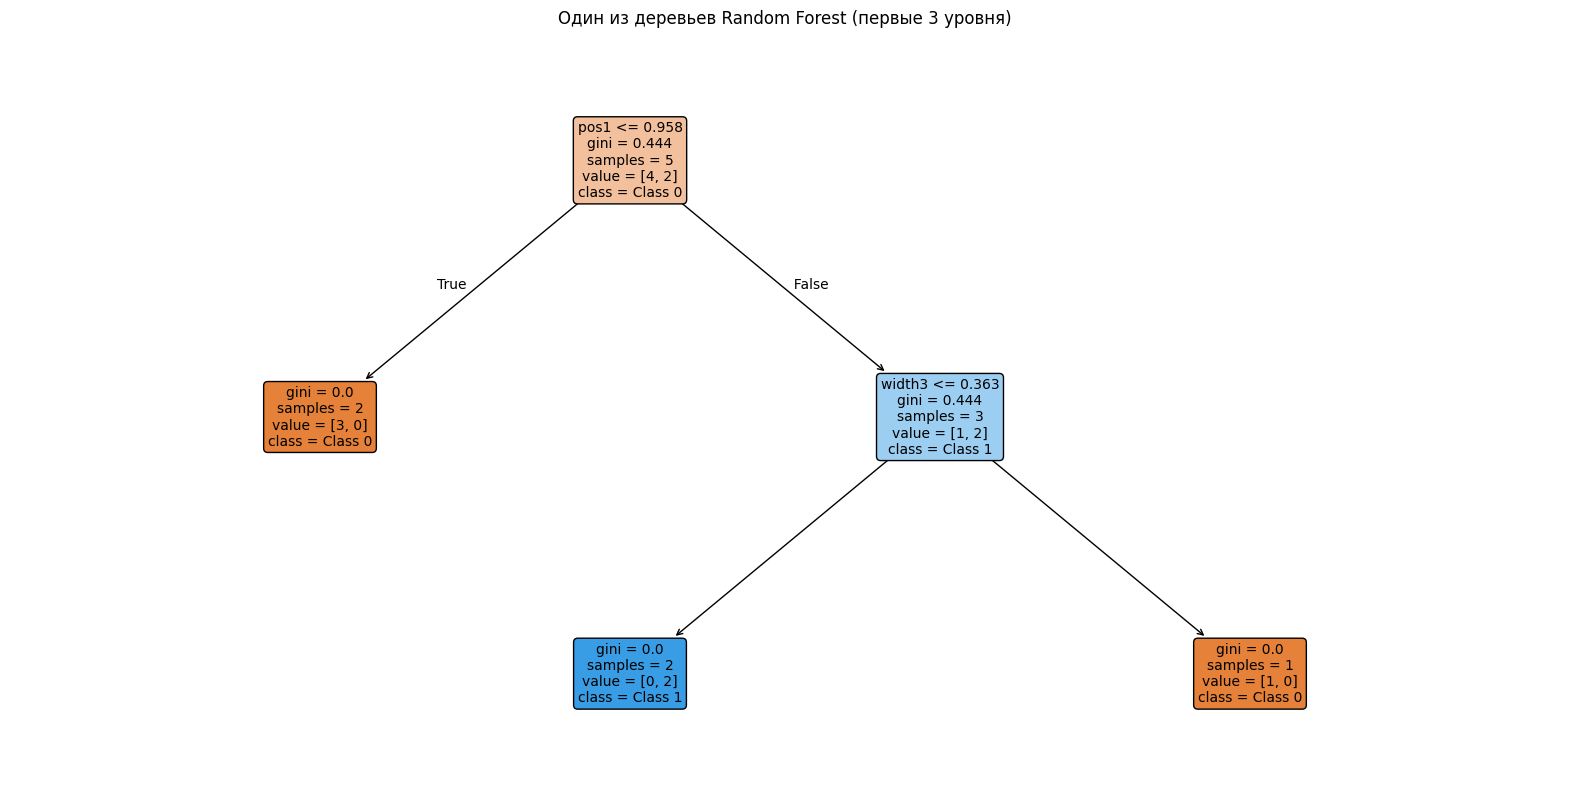

In [11]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Предположим, grid — это уже обученный GridSearchCV
best_clf = grid.best_estimator_.named_steps['clf']
tree = best_clf.estimators_[2]

# Имена признаков (для top_n=10)
feature_names = []
for i in range(1, 11):
    feature_names += [f"pos{i}", f"height{i}", f"width{i}"]

plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=['Class 0', 'Class 1'],
    filled=True,
    rounded=True,
    max_depth=5,  # показываем первые 3 уровня
    fontsize=10
)
plt.title("Один из деревьев Random Forest (первые 3 уровня)")
plt.show()


In [13]:
# Пример: показать частоту пиков по всем спектрам
peak_positions_all = []
for row in X_scaled:
    peaks, _ = find_peaks(row, prominence=0.02, distance=2)
    peak_positions = binned_wavs[peaks]
    peak_positions_all.extend(peak_positions)

# Округлим до 5 см⁻¹ и посчитаем частоту
from collections import Counter
counts = Counter(np.round(peak_positions_all, -1))
print(counts.most_common(10))


[(np.float64(1600.0), 4), (np.float64(2920.0), 4), (np.float64(1160.0), 2), (np.float64(2150.0), 1), (np.float64(2480.0), 1), (np.float64(2810.0), 1), (np.float64(1930.0), 1), (np.float64(2260.0), 1), (np.float64(1490.0), 1), (np.float64(1380.0), 1)]


In [3]:
import pandas as pd
df = pd.read_csv("FINAL.csv")
df

,Unnamed: 0,spectrumID,400.1202,400.6023,401.0844,401.5665,402.0486,402.5308,403.0129,403.495,...,3496.273,3496.756,3497.238,3497.72,3498.202,3498.684,3499.166,3499.648,3500.13,Class
0,0,0,13.623470,13.608400,13.633900,13.612130,13.49463,13.405410,13.443150,13.670980,...,11.860640,11.923890,12.115200,12.163440,12.071620,11.882160,11.922870,12.065420,12.133940,0
1,1,1,16.702800,16.597580,16.741700,16.890020,17.09677,17.224010,17.167970,16.870630,...,18.001020,17.662610,17.976970,18.014010,17.856410,17.690950,17.856570,18.079690,18.099250,0
2,2,2,0.412945,0.391413,0.427336,0.615879,0.77862,0.776802,0.591732,0.470215,...,0.654684,0.675116,0.662451,0.651077,0.629126,0.608711,0.643103,0.799446,0.886864,0
3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
